<a href="https://colab.research.google.com/github/ThuanPhong0126/CS114.K21/blob/master/Project/Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Kết nối google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load Data

Import các thư viện cần thiết

In [24]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt


Load dữ liệu được lưu trên github

In [4]:
df=pd.read_excel('https://github.com/ThuanPhong0126/CS114.K21/blob/master/Project/final_data.xlsx?raw=true')
df

,Unnamed: 0,text,label
0,0,Không có chào đón như trong giới thiệu,0
1,1,"Lựa chọn tốt cho du lịch nhóm ,gia đình",1
2,2,"phòng yên tĩnh dù sát mặt đường lớn , sạch sẽ.",1
3,3,phòng sạch đẹp,1
4,4,"Khách sạn sạch sẽ, gần biển, gần siêu thị Lott...",1
...,...,...,...
4119,145,Thôi thì treo biển không nhận khách đi oto cho...,0
4120,146,12 giờ đêm về thì khách sạn tối hin,0
4121,147,Nói 3 sao thì hơi quá.,0
4122,148,"Thua khách sạn mình ở Nha Trang, Vẫn 3 sao.",0


Dữ liệu gồm có 3 cột là Unnamed: 0, text và label. Trong đó text chứ bình luận, label chứa nhãn tương ứng và cột Unnamed: 0 không có tác dụng nên xóa cột Unnamed: 0

In [5]:
del df['Unnamed: 0']
df

,text,label
0,Không có chào đón như trong giới thiệu,0
1,"Lựa chọn tốt cho du lịch nhóm ,gia đình",1
2,"phòng yên tĩnh dù sát mặt đường lớn , sạch sẽ.",1
3,phòng sạch đẹp,1
4,"Khách sạn sạch sẽ, gần biển, gần siêu thị Lott...",1
...,...,...
4119,Thôi thì treo biển không nhận khách đi oto cho...,0
4120,12 giờ đêm về thì khách sạn tối hin,0
4121,Nói 3 sao thì hơi quá.,0
4122,"Thua khách sạn mình ở Nha Trang, Vẫn 3 sao.",0


Trong bộ data có tất cả 4124 bình luận.

Biểu đồ thống kê số lượng nhãn tương ứng với mỗi label

1    2476
0    1648
Name: label, dtype: int64


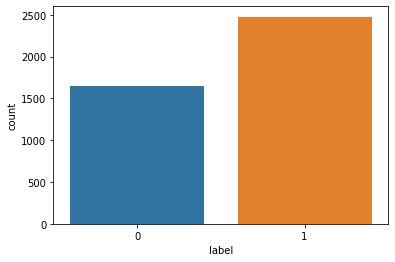

In [11]:
print(df['label'].value_counts())
sns.countplot(df['label'])
plt.show()

**Nhận xét:** Trong bộ data có tất cả 4124 câu bình luận trong đó bình luận tích cực (label 1) là 2476 bình luận (chiếm 60,04%) và bình luận tiêu cực (label 0) là 1648 bình luận (chiếm 39,96%).

* Thư viện pyvi được cài đặt để sử dụng cho việc phân chia từ trong tiếng việt

In [13]:
!pip install pyvi

     |████████████████████████████████| 8.5MB 2.5MB/s 
     |████████████████████████████████| 747kB 36.6MB/s 


In [17]:
from pyvi import ViTokenizer
def Token(t):
  return ViTokenizer.tokenize(t)

def standardize_data(t):

  t = t.lower()
  t = t.replace(',', ' ').replace('.', ' ')\
      .replace(";", " ").replace("“", " ") \
      .replace(":", " ").replace("”", " ") \
      .replace('"', " ").replace("'", " ") \
      .replace("!", " ").replace("?", " ").replace("-", " ").replace("?", " ") 
  t = t.strip()
  return t

* Hàm Token có nhiệm vụ thực hiện việc phân chia các từ trong tiếng việt.
Ví dụ:

In [16]:
print(Token('Khách sạn nằm ở vị trí trung tâm của thành phố'))

Khách_sạn nằm ở vị_trí trung_tâm của thành_phố


* Hàm standardize_data nhận đầu vào là một bình luận và nó có nhiệm vụ chuyển bình luận về chữ thường, xóa các dấu câu đặc biệt (, . ; " : ' ! ? -) và xóa các khoảng trống ở đâu và cuối bình luận. Ví dụ:

In [20]:
print(standardize_data('kHÁCH sạn này có vị trí thuận tiện Đi lại!!!   '))

khách sạn này có vị trí thuận tiện đi lại


### Không phân tích theo nghĩa tiếng việt _ phân theo dấu cách

Thực hiện hàm standardize_data trên tất cả các bình luận có trong bộ dữ liệu. Và thu được một dataframe mới như bên dưới.

In [45]:
df['text'] = df['text'].apply(standardize_data)
df

,text,label
0,không có chào đón như trong giới thiệu,0
1,lựa chọn tốt cho du lịch nhóm gia đình,1
2,phòng yên tĩnh dù sát mặt đường lớn sạch sẽ,1
3,phòng sạch đẹp,1
4,khách sạn sạch sẽ gần biển gần siêu thị lott...,1
...,...,...
4119,thôi thì treo biển không nhận khách đi oto cho...,0
4120,12 giờ đêm về thì khách sạn tối hin,0
4121,nói 3 sao thì hơi quá,0
4122,thua khách sạn mình ở nha trang vẫn 3 sao,0


In [72]:
X_tr, X_t, y_train, y_test =train_test_split(df['text'], df['label'], test_size=0.2, random_state=33)

Phân chia dữ liệu với 80% làm tập train và 20% làm tập test

In [73]:
X_t

200                  gần biển  phòng sạch  cảnh quang đẹp
1980    gia đình mình đến sớm được hỗ trợ gửi hành lý ...
2999    địa điểm trung tâm thành phố  thuận tiện cho c...
1973     phòng đẹp hồ bơi sạch bọn trẻ nhà mình rất thích
2493               lễ tân phục vụ rất nhiệt tình  chu đáo
                              ...                        
2939    khách sạn sạch sẽ  cô chú rất dễ thương và tốt...
3168                                 kì nghỉ rất đáng nhớ
3626    cửa phòng là kính sáng màu nên ban ngày trong ...
3206                                       ăn sáng hơi tệ
1722                           dọn phòng rất sạch sẽ luôn
Name: text, Length: 825, dtype: object

Tập test có 825 bình luận

In [74]:
X_tr

2765                     nhân viên thân thiện  nhiệt tình
3835    theo thông tin mô tả phòng rộng 50m   có đầy đ...
3872    vợ chồng mình có đặt phòng junior suite (theo ...
261     phòng rất sạch và đẹp  mình ở phòng có view ra...
2036      khách sạn đẹp  nhân viên tận tình  ăn sáng ngon
                              ...                        
57                                                sạch sẽ
3273                       bàn ghế và sàn nhà hơi bụi bặm
2706    phòng nghỉ sạch sẽ  nhân viên nhiệt tình  phòn...
578     đồ ăn ngon tuy nhiên chưa phong phú  không gia...
2439    phòng rất sạch sẽ và thoáng mát  tiện nghi tro...
Name: text, Length: 3299, dtype: object

Tập train có 3299 bình luận

Tiêp theo đến việc chuyển các bình luận về các vector đặc trưng.


#### TF-IDF

Phương pháp đầu tiên sử dụng là TF-IDF. Phương pháp này sẽ tạo ra một túi từ vựng bằng tất cả các từ có trong bộ dữ liệu. Sau đó chuyển các bình luận về dạng vector đặc trung với mỗi vector có độ dài bằng số lượng từ vựng trong túi từ vựng và tính độ quan trọng của mỗi từ trong túi từ vựng đối với bình luận đang xét. Và phương pháp tính Tf-idf được hỗ trợ bởi thư viện scikit-learn

In [75]:
emb=TfidfVectorizer()
emb.fit(df['text'])
X_train=emb.transform(X_tr)
X_test=emb.transform(X_t)

Emb được lưu lại để sử dụng cho việc sau này như việc dự đoán một câu bất kỳ được nhập vào. Và file này sẽ được upload lên github cho việc sử dụng thuận tiện hơn.

In [76]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_cach.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_cach.pkl']

##### Lựa chọn model

Lựa chọn model, sử dụng 5 model: BernoulliNB, Logistic Regression,SVC, Randomforest, Decision Tree cho mỗi phương pháp feature engineering khác nhau. Và từ đó so sánh và chọn ra model tốt nhất.

**Model đầu tiên: BernoulliNB**

In [77]:
from sklearn.naive_bayes import BernoulliNB
model=BernoulliNB()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy:  ',accuracy_score(y_test,predict))
print('Classification report: \n',classification_report(y_test,predict))
print('Confusion matrix: \n',confusion_matrix(y_test,predict))

Accuracy:   0.8909090909090909
Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.85      0.86       321
           1       0.90      0.92      0.91       504

    accuracy                           0.89       825
   macro avg       0.89      0.88      0.88       825
weighted avg       0.89      0.89      0.89       825

Confusion matrix: 
 [[272  49]
 [ 41 463]]


*Accuracy*: 89,09% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận.

*Classification report*: trong tập test có 321 bình luận nhãn 0, 504 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 86% và 91% với 

f1-score=2 x (recall x precision)/(recall + precision) trong đó: 

recall nhãn 0 = (số lượng bình luận nhãn 0 được model dự đoán chính xác) / (số lượng bình luận nhãn  trong thực tế)

precision nhãn 0 = (số lượng bình luận nhãn 0 được model dự đoán chính xác) / (số lượng bình luận nhãn 0 được model dự đoán)

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.89. (0.89= 0.86.(321/825)+0.9.(504/825))

*Confsusion matrix*: Trong 321 bình luận nhãn 0 thì model dự đoán chính xác 272 bình luận và 504 bình luận nhãn 1 thì model dự đoán chính xác 463 bình luận => accuracy = (272+463) / 825 = 0,8809

---



**Model thứ hai: LogisticRegression**

In [78]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.936969696969697
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       321
           1       0.96      0.93      0.95       504

    accuracy                           0.94       825
   macro avg       0.93      0.94      0.93       825
weighted avg       0.94      0.94      0.94       825

[[303  18]
 [ 34 470]]


*Accuracy*: 93.69% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 321 bình luận nhãn 0, 504 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 92% và 95% với

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.94. (0.94= 0.92.(321/825)+0.95.(504/825))

*Confsusion matrix*: Trong 321 bình luận nhãn 0 thì model dự đoán chính xác 303 bình luận và 504 bình luận nhãn 1 thì model dự đoán chính xác 470 bình luận => accuracy = (303+470) / 825 = 0,9369

---

**Model thứ ba: RandomForest**


In [79]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9236363636363636
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       321
           1       0.95      0.92      0.94       504

    accuracy                           0.92       825
   macro avg       0.92      0.92      0.92       825
weighted avg       0.92      0.92      0.92       825

[[296  25]
 [ 38 466]]


*Accuracy*: 92.36% là độ chính xác và được tính là số lượng bình luận dự đoán đúng / tổng số bình luận đem dự đoán.

*Classification report*: trong tập test có 321 bình luận nhãn 0, 504 bình luận nhãn 1. Trong đó f1-score của nhãn 0 và 1 tương ứng là 90% và 94%

Và f1-score trung bình theo cách tính weighted avg (có nhân với tỷ lệ của số lượng nhãn) là 0.92. (0.92= 0.90.(321/825)+0.94.(504/825))

Confsusion matrix: Trong 321 bình luận nhãn 0 thì model dự đoán chính xác 296 bình luận và 504 bình luận nhãn 1 thì model dự đoán chính xác 466 bình luận => accuracy = (296+466) / 825 = 0,9236

In [ ]:
from sklearn.svm import SVC
model=SVC()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9490909090909091
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       350
           1       0.97      0.94      0.96       475

    accuracy                           0.95       825
   macro avg       0.95      0.95      0.95       825
weighted avg       0.95      0.95      0.95       825

[[335  15]
 [ 27 448]]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test,predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.8848484848484849
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       350
           1       0.89      0.91      0.90       475

    accuracy                           0.88       825
   macro avg       0.88      0.88      0.88       825
weighted avg       0.88      0.88      0.88       825

[[297  53]
 [ 42 433]]


 #### CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
X=df['text']
y=df['label']
emb=CountVectorizer().fit(X)
X_train,X_test, y_train, y_test=train_test_split(X , y , test_size=0.2)
X_train=emb.transform(X_train)
X_test=emb.transform(X_test)

In [ ]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/countvr_cach.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/countvr_cach.pkl']

In [ ]:
model=GaussianNB().fit(X_train.toarray(),y_train)
predict=model.predict(X_test.toarray())
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.7660606060606061
              precision    recall  f1-score   support

           0       0.83      0.52      0.64       328
           1       0.75      0.93      0.83       497

    accuracy                           0.77       825
   macro avg       0.79      0.72      0.73       825
weighted avg       0.78      0.77      0.75       825

[[170 158]
 [ 35 462]]


In [ ]:
model=BernoulliNB().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.8581818181818182
              precision    recall  f1-score   support

           0       0.84      0.79      0.82       328
           1       0.87      0.90      0.88       497

    accuracy                           0.86       825
   macro avg       0.86      0.85      0.85       825
weighted avg       0.86      0.86      0.86       825

[[259  69]
 [ 48 449]]


In [ ]:
model=SVC().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9224242424242424
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       328
           1       0.95      0.92      0.93       497

    accuracy                           0.92       825
   macro avg       0.92      0.92      0.92       825
weighted avg       0.92      0.92      0.92       825

[[304  24]
 [ 40 457]]


In [ ]:
model=RandomForestClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.926060606060606
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       328
           1       0.96      0.92      0.94       497

    accuracy                           0.93       825
   macro avg       0.92      0.93      0.92       825
weighted avg       0.93      0.93      0.93       825

[[308  20]
 [ 41 456]]


In [ ]:
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.8884848484848484
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       328
           1       0.91      0.91      0.91       497

    accuracy                           0.89       825
   macro avg       0.88      0.88      0.88       825
weighted avg       0.89      0.89      0.89       825

[[282  46]
 [ 46 451]]


In [ ]:
model=LogisticRegression().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9478787878787879
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       328
           1       0.95      0.96      0.96       497

    accuracy                           0.95       825
   macro avg       0.95      0.94      0.95       825
weighted avg       0.95      0.95      0.95       825

[[305  23]
 [ 20 477]]


### Pyvi

In [ ]:
df['text'] = df['text'].apply(standardize_data)
df['text'] = df['text'].apply(Token)
df

,text,label
0,không có chào_đón như trong giới_thiệu,0
1,lựa_chọn tốt cho du_lịch nhóm gia_đình,1
2,phòng yên_tĩnh dù sát mặt_đường lớn sạch_sẽ,1
3,phòng sạch đẹp,1
4,khách_sạn sạch_sẽ gần biển gần siêu_thị lotte ...,1
...,...,...
4119,thôi_thì treo biển không nhận khách đi oto cho...,0
4120,12 giờ đêm về thì khách_sạn tối hin,0
4121,nói 3 sao thì hơi quá,0
4122,thua khách_sạn mình ở nha trang vẫn 3 sao,0


#### TF-IDF

In [ ]:
emb=TfidfVectorizer().fit(df['text'])

In [ ]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_pyvi.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/tfidf_pyvi.pkl']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2)

In [ ]:
X_train=emb.transform(X_train)
X_test=emb.transform(X_test)

In [ ]:
X_train

<3299x3212 sparse matrix of type '<class 'numpy.float64'>'
	with 34783 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.naive_bayes import BernoulliNB
model=BernoulliNB()
model.fit(X_train,y_train)
predict=model1.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test, predict))
print(confusion_matrix(y_test, predict))

Accuracy:  0.9187878787878788
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       327
           1       0.90      0.97      0.94       498

    accuracy                           0.92       825
   macro avg       0.93      0.90      0.91       825
weighted avg       0.92      0.92      0.92       825

[[274  53]
 [ 14 484]]


In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9515151515151515
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       327
           1       0.95      0.97      0.96       498

    accuracy                           0.95       825
   macro avg       0.95      0.95      0.95       825
weighted avg       0.95      0.95      0.95       825

[[303  24]
 [ 16 482]]


In [ ]:
from sklearn.svm import SVC
model=SVC().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9575757575757575
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       327
           1       0.97      0.96      0.96       498

    accuracy                           0.96       825
   macro avg       0.96      0.96      0.96       825
weighted avg       0.96      0.96      0.96       825

[[310  17]
 [ 18 480]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9490909090909091
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       327
           1       0.96      0.96      0.96       498

    accuracy                           0.95       825
   macro avg       0.95      0.95      0.95       825
weighted avg       0.95      0.95      0.95       825

[[306  21]
 [ 21 477]]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9103030303030303
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       327
           1       0.92      0.93      0.93       498

    accuracy                           0.91       825
   macro avg       0.91      0.90      0.91       825
weighted avg       0.91      0.91      0.91       825

[[287  40]
 [ 34 464]]


#### CountVecterizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( df['text'], df['label'], test_size=0.2)

In [ ]:
emb=CountVectorizer().fit(df['text'])

X_train=emb.transform(X_train)
X_test=emb.transform(X_test)

In [ ]:
joblib.dump(emb, '/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/Count_pyvi.pkl')

['/content/drive/My Drive/Colab Notebooks/ML/DoAnCuoiKy/Count_pyvi.pkl']

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [ ]:
model=BernoulliNB().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.8775757575757576
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       332
           1       0.86      0.95      0.90       493

    accuracy                           0.88       825
   macro avg       0.88      0.86      0.87       825
weighted avg       0.88      0.88      0.88       825

[[258  74]
 [ 27 466]]


In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9454545454545454
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       332
           1       0.95      0.96      0.95       493

    accuracy                           0.95       825
   macro avg       0.95      0.94      0.94       825
weighted avg       0.95      0.95      0.95       825

[[305  27]
 [ 18 475]]


In [ ]:
from sklearn.svm import SVC
model=SVC().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9309090909090909
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       332
           1       0.94      0.94      0.94       493

    accuracy                           0.93       825
   macro avg       0.93      0.93      0.93       825
weighted avg       0.93      0.93      0.93       825

[[304  28]
 [ 29 464]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.9296969696969697
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       332
           1       0.94      0.94      0.94       493

    accuracy                           0.93       825
   macro avg       0.93      0.93      0.93       825
weighted avg       0.93      0.93      0.93       825

[[304  28]
 [ 30 463]]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier().fit(X_train,y_train)
predict=model.predict(X_test)
print('Accuracy: ',accuracy_score(y_test, predict))
print(classification_report(y_test,predict))
print(confusion_matrix(y_test,predict))

Accuracy:  0.8872727272727273
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       332
           1       0.90      0.92      0.91       493

    accuracy                           0.89       825
   macro avg       0.88      0.88      0.88       825
weighted avg       0.89      0.89      0.89       825

[[279  53]
 [ 40 453]]


### Dự đoán một câu mới được nhập vào
Nếu nhập vào comment gồm nhiều câu sẽ được tách thành các câu riêng rồi dự đoán trên mỗi câu

In [ ]:
comment=input()
feature=pd.Series(comment.split('.'))
feature = feature.apply(standardize_data)
feature = feature.apply(Token)
feature=emb.transform(feature)
predict=model.predict(feature)
print(predict)

Khách sạn quá tệ nhưng bù lại nằm ở vị trí trung tâm
[0]


In [ ]:
from pyvi import ViTokenizer
def Token(t):
  return ViTokenizer.tokenize(t)

print(Token('Khách sạn nằm tại trung tâm thành phố'))

Khách_sạn nằm tại trung_tâm thành_phố
